In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, InputLayer, Flatten, BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import BinaryCrossentropy


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data preparation

In [5]:
dataset, dataset_info = tfds.load('malaria', with_info=True,
                                  as_supervised=True, 
                                  shuffle_files = True, 
                                  split=['train'])

In [6]:
# Export to csv
np_dataset = tfds.as_numpy(dataset[0])
np_dataset = list(np_dataset)
training_dict = {"Image": [], "Res": []}
for item in dataset[0]:
    training_dict["Image"].append(list(item[0].numpy()))
    training_dict["Res"].append(item[1].numpy())

len(training_dict["Image"])

27558

In [7]:
data = pd.read_csv('list.csv')
data.head()

,Unnamed: 0,Image,Res
0,0,"[array([[ 0, 0, 0],\n [ 0, 0, ...",1
1,1,"[array([[ 0, 0, 0],\n [ 0, 0, ...",1
2,2,"[array([[ 0, 0, 0],\n [ 0, 0, ...",0
3,3,"[array([[ 0, 0, 0],\n [ 0, 0, ...",1
4,4,"[array([[ 0, 0, 0],\n [ 0, 0, ...",1


In [8]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)

    train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

    val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

    test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
    return train_dataset, val_dataset, test_dataset

In [9]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
list(train_dataset.take(1).as_numpy_iterator())

[(array([[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         ...,
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]], dtype=uint8),
  0)]

In [10]:
for data in dataset[0].take(4):
    print(data)

(<tf.Tensor: shape=(151, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(121, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

### Dataset visualization

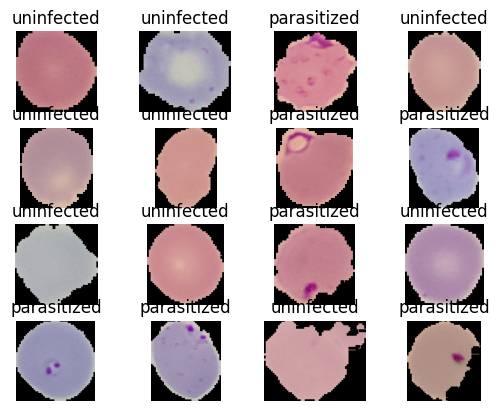

In [11]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

### Data preprocessing

In [12]:
IM_SIZE = 224
def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [13]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [14]:
for image, label in train_dataset.take(1):
    print(image)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32)


In [15]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


### Model creation

In [16]:
lenet_model = tf.keras.Sequential([
                             InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

                             Conv2D(filters=6, kernel_size=5, strides=1, padding='valid', activation='relu'),
                             BatchNormalization(),
                             MaxPooling2D(pool_size=2, strides=2),

                             Conv2D(filters=16, kernel_size=5, strides=1, padding='valid', activation='relu'),
                             BatchNormalization(),
                             MaxPooling2D(pool_size=2, strides=2),

                             Flatten(),
                             Dense(100, activation='relu'),
                             BatchNormalization(),
                             Dense(10, activation='relu'),
                             BatchNormalization(),
                             Dense(1, activation='sigmoid'),
])
lenet_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 6)       456       
                                                                 
 batch_normalization (Batch  (None, 220, 220, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 batch_normalization_1 (Bat  (None, 106, 106, 16)      64        
 chNormalization)                                                
                                                        

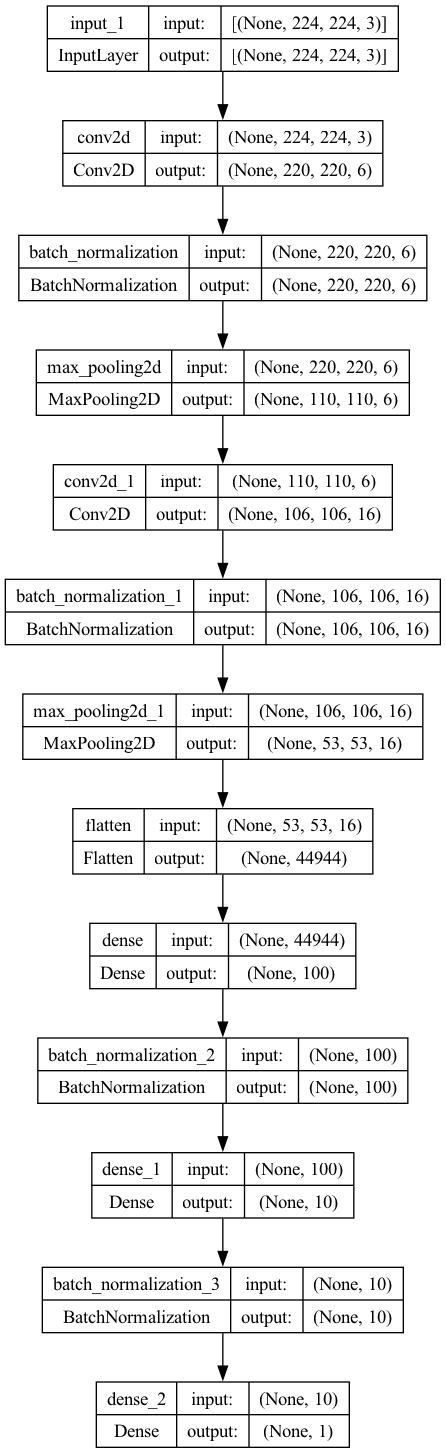

In [17]:
tf.keras.utils.plot_model(model=lenet_model, to_file="model.png", show_shapes=True)

### Checking losses by binary Crossentropy loss

In [18]:
lenet_model.compile(optimizer=Adam(learning_rate=0.01),
              loss=BinaryCrossentropy(),
              metrics='accuracy')

In [20]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=2, verbose=1)

Epoch 1/2
689/689 [==============================] - 176s 255ms/step - loss: 0.2076 - accuracy: 0.9299 - val_loss: 0.2499 - val_accuracy: 0.9194
Epoch 2/2
689/689 [==============================] - 175s 254ms/step - loss: 0.1802 - accuracy: 0.9399 - val_loss: 0.2807 - val_accuracy: 0.9274


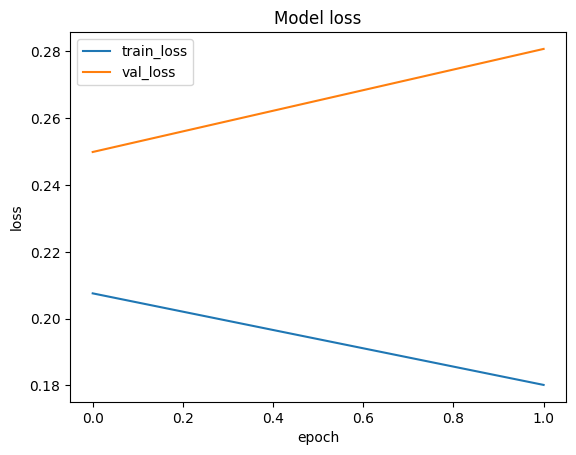

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

### Model evaluation and testing

In [22]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [23]:
lenet_model.evaluate(test_dataset)

87/87 [==============================] - 7s 56ms/step - loss: 0.2905 - accuracy: 0.9227


[0.29049861431121826, 0.9227421283721924]

### Making prediction by model

In [24]:
def isParasitized(res: float):
    if res > 0.5:
        return "Unparas"
    else:
        return "Paras"

In [25]:
isParasitized(lenet_model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 2s 2s/step


'Unparas'

In [26]:
test_dataset = test_dataset.shuffle(buffer_size=8)

1/1 [==============================] - 0s 61ms/step
[0.9958098]
1/1 [==============================] - 0s 60ms/step
[0.00239668]
1/1 [==============================] - 0s 60ms/step
[0.00347113]
1/1 [==============================] - 0s 61ms/step
[0.9411523]
1/1 [==============================] - 0s 60ms/step
[0.92615485]
1/1 [==============================] - 0s 59ms/step
[0.9948705]
1/1 [==============================] - 0s 62ms/step
[0.9796292]
1/1 [==============================] - 0s 60ms/step
[0.99090666]
1/1 [==============================] - 0s 59ms/step
[0.96889615]


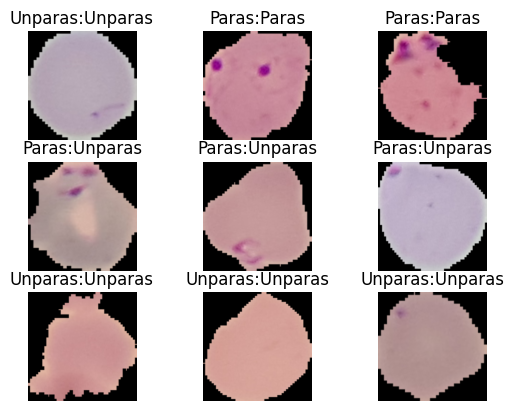

In [27]:
for i, (image, label) in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0])
    plt.title(str(isParasitized(label.numpy()[0])) + ":" + str(isParasitized(lenet_model.predict(image)[0][0])))
    print(lenet_model.predict(image)[0])
    plt.axis('off')